# 2D Vis

This code is super messy - TODO: Clean

- Improve 2D vis code then move it to utils

In [11]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset, Dataset, concatenate_datasets, load_from_disk

import os
import sys

sys.path.insert(0, "../src/")
sys.path.insert(0, "..")
from config import REPO_ROOT

from utils import scoring_function, postprocessing
from tqdm import tqdm
import json
from torch.utils.data import DataLoader
import time
import traceback
import numpy as np
import random
import re
import os
import nltk
import string
import argparse
import gc
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
import matplotlib.colors as mcolors
%config InlineBackend.figure_format = 'svg'
from matplotlib.lines import Line2D


import warnings
warnings.filterwarnings("ignore")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

## Discrete

In [12]:
def plot_decision_boundary_new(
        model_name,
        dataset_name,
        variables,
        colours=["#fdae61", "#abd9e9"],
        save_path=None,
        verbose=0,
        points_to_mark_1=0,      
        points_to_mark_2=0,
        offset=0,
        cf_density=False,
        filepath=False,
        lengend_setting=False):
    """
    The main function for plotting 2D decisino boundaries. Lots of featuers available.
    """

    # Get verification results and convert keys to int.
    if filepath!=False:
        results = postprocessing(filepath, force=True, distance_metric="gower", save=True, explicit_dataset="")
    else:
        results = postprocessing(REPO_ROOT / f'results/{dataset_name}/{model_name}.json', force=True, distance_metric="gower", save=True, explicit_dataset="")

    results = {int(k): v for k, v in results.items()}

    alpha = 0.5  # Adjust as needed (0=transparent, 1=opaque)
    colours_with_alpha = [mcolors.to_rgba(c, alpha=alpha) for c in colours]


    ###########################################################################
    # Load dataset metadata and data.
    ###########################################################################
    with open(REPO_ROOT / 'src/models_datasets/datasets.json', 'r') as file:
        datasets_dict = json.load(file)
    ds_info = datasets_dict[dataset_name]
    if ds_info.get('local', False):
        dataset = load_from_disk(REPO_ROOT / ds_info['filepath'])
    else:
        dataset = load_dataset(ds_info['filepath'], name=ds_info['name'], split=ds_info['split'])
    id_to_index = {id_: idx for idx, id_ in enumerate(dataset['id'])}

    # Encode decision options.
    options = ds_info['options']
    option_to_code = {option: code for code, option in enumerate(options)}

    ###########################################################################
    # Update results with meta-data and collect plotting values.
    ###########################################################################
    var_0 = []
    var_1 = []
    model_decision = []
    for v in tqdm(results.values()):
        dataset_id = v.get('dataset_id')
        idx = id_to_index.get(dataset_id)
        if idx is not None:
            v[variables[0]] = dataset[idx][variables[0]]
            v[variables[1]] = dataset[idx][variables[1]]
        else:
            v[variables[0]] = np.nan
            v[variables[1]] = np.nan

        v['ground_truth_int'] = option_to_code.get(v.get('ground_truth'), 'NA')
        v['model_decision_int'] = option_to_code.get(v.get('original_answer'), 'NA')

        var_0.append(v[variables[0]])
        var_1.append(v[variables[1]])
        decision_val = v['model_decision_int']
        model_decision.append(np.nan if decision_val == 'NA' else decision_val)

    var_0 = np.array(var_0)
    var_1 = np.array(var_1)
    model_decision = np.array(model_decision)

    ###########################################################################
    # Bin the data using a custom unique statistic function.
    ###########################################################################
    def unique_value(x):
        ux = np.unique(x)
        return ux[0] if len(ux) == 1 else np.nan

    bins_var_0 = np.arange(np.min(var_0), np.max(var_0) + 2, 1)
    bins_var_1 = np.arange(np.min(var_1), np.max(var_1) + 2, 1)

    stat, x_edges, y_edges, binnumber = binned_statistic_2d(
        var_0, var_1, model_decision, statistic=unique_value, bins=[bins_var_0, bins_var_1]
    )

    # Determine unique categories for the decisions.
    categories = np.sort(np.unique(model_decision[~np.isnan(model_decision)]))
    N = len(categories)
    cat_to_index = {cat: i for i, cat in enumerate(categories)}

    # Map each binned value to its corresponding discrete index.
    def map_category(val):
        return cat_to_index.get(float(val), -1) if not np.isnan(val) else -1
    stat_indices = np.vectorize(map_category)(stat)  
    stat_indices = np.ma.masked_where(stat_indices == -1, stat_indices)   ###### Comment out if you want smooth boundary

    ###########################################################################
    # Plot the discrete heatmap.
    ###########################################################################
    # Create a discrete colormap with N colors interpolated between the two endpoint colors.
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colours_with_alpha, N)
    norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, N + 0.5), ncolors=N)

    plt.figure(figsize=(8, 8))
    plt.imshow(stat_indices.T, origin='lower', aspect='auto',
               extent=[bins_var_0[0], bins_var_0[-1], bins_var_1[0], bins_var_1[-1]],
               cmap=cmap, norm=norm, alpha=0.95)

    ###########################################################################
    # Create a legend with colored squares instead of a colorbar.
    ###########################################################################
    import matplotlib.patches as mpatches
    legend_handles = []
    for cat in categories:
        idx = cat_to_index[cat]
        # Normalize the index to the range [0, 1] for the colormap.
        norm_val = idx / (N - 1) if N > 1 else 0
        patch_color = cmap(norm_val)
        patch = mpatches.Patch(color=patch_color, label=f"Decision {cat}")
        legend_handles.append(patch)


    ###########################################################################
    # Optionally plot counter-factual densities for two groups.
    ###########################################################################
    colours_dots = ['#0D47A1','#E65100']
    groups = [
        (points_to_mark_1, colours_dots[0],  'Group 1'),   # (parameter, colour, label)
        (points_to_mark_2, colours_dots[1], 'Group 2')
    ]

    for pts, colour, label in groups:
        if not pts:                              # skip an empty / zero entry
            continue

        # ── pick sample IDs exactly as before ────────────────────────────────
        if isinstance(pts, int):
            keys    = list(results.keys())
            samples = random.sample(keys, pts)
            if verbose:
                print(f'{label} randomly selected IDs ➜', samples)
        else:                                    # the caller passed an explicit list
            samples = pts

        # ── collect CF coordinates per decision class ────────────────────────
        classes = ds_info['options']
        class_counterfactuals = {c: {"x": [], "y": []} for c in classes}

        for i in samples:
            try:
                variables_CF = [x + "_CF" for x in variables]
                v_cf = [results[i][var] for var in variables_CF]

                CF_target = results[i]['selected_complement']
                class_counterfactuals[CF_target]["x"].append(v_cf[0] + offset)
                class_counterfactuals[CF_target]["y"].append(v_cf[1] + offset)

            except Exception:
                continue

        # ── plot the density cloud for this group ────────────────────────────
        for coords in class_counterfactuals.values():
            plt.scatter(coords["x"], coords["y"],
                        c=colour, alpha=0.15, s=80, edgecolors='none')

        # ── add a legend handle (optional) ────────────────────────────────────
        legend_handles.append(
            Line2D([], [], marker='o', linestyle='None',
                markerfacecolor=colour, markeredgecolor=colour, alpha=0.4,
                markersize=10, label=f'{label} densities')
        )

        # keep the rest of the code (combined_handles, legend, save, show) unchanged


        if verbose>0:
            print("\nCollected counterfactual coordinates by class:")
            for cls, coords in class_counterfactuals.items():
                print(f"Class {cls}: {coords}")
        ###########################################################################

        # Create custom handles for scatter points.
        original_handle = Line2D([], [], marker='x', linestyle='None',
                                markerfacecolor='red', markeredgecolor='red',
                                markersize=8, label='Original inputs')
        counter_handle = Line2D([], [], marker='x', linestyle='None',
                                markerfacecolor='c', markeredgecolor='c',
                                markersize=8, label='Counterfactuals')

        counter_handle_2 = Line2D([], [], marker='o', linestyle='None',
                                markerfacecolor='k', markeredgecolor='k',
                                markersize=8, label='SCEs')

        combined_handles = legend_handles + [original_handle, counter_handle]
        combined_handles = legend_handles + [counter_handle_2]

    else:
        combined_handles = legend_handles

    
    

    plt.legend(handles=combined_handles, loc='lower right')

    # 1) Build the handles you want to see. ["#fdae61", "#abd9e9"]
    legend_handles = [
        Patch(facecolor=colours_with_alpha[1], edgecolor=colours_with_alpha[1], label='Above $50,000'),
        Patch(facecolor=colours_with_alpha[0],   edgecolor=colours_with_alpha[0],   label='Below $50,000'),
        Line2D([], [], marker='o', linestyle='None',
            markerfacecolor=colours_dots[0], alpha=0.5,      
            markersize=8, label='SCEs targeting above $50,000', markeredgecolor='none'),
        Line2D([], [], marker='o', linestyle='None',
            markerfacecolor=colours_dots[1], alpha=0.5,      
            markersize=8, label='SCEs targeting below $50,000', markeredgecolor='none')
    ]

    # 2) Remove any legend that might already exist
    ax = plt.gca()                  # or keep a reference to the axes earlier
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    # 3) Draw the new legend (edit kwargs to taste)
    if lengend_setting == True:
        legend = ax.legend(handles=legend_handles,
                       loc='lower left',
                       frameon=True,
                       fontsize=16)

        legend.get_frame().set_edgecolor('grey')  # remove just the legend border

    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', transparent=True, dpi=300)

    plt.show()

    return results

Extracted Dataset Name: income


  0%|          | 0/1920 [00:00<?, ?it/s]

100%|██████████| 1920/1920 [00:00<00:00, 7603.59it/s]


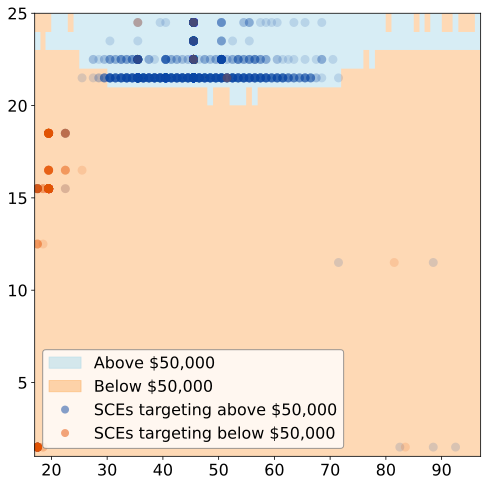

In [14]:
# started_below = []
# started_above = []
results = plot_decision_boundary_new("gpt4_1", 'income', ['AGEP', 'SCHL'], verbose=0, points_to_mark_1=started_below, points_to_mark_2=started_above
, offset=0.5, cf_density=True, filepath = "../results/income/gpt4_1.json",
save_path = REPO_ROOT / "figures/decision_boundary.png", lengend_setting=True)

In [8]:
results
started_below = []
started_above = []
for k,v in results.items():
    if v['original_answer']=='Below $50,000':
        started_below.append(k)
    else:
        started_above.append(k)

# Discrete decision boundaries for high-dimensional settings

# Continuous decision boundaries

In [19]:
import json
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from scipy.stats import binned_statistic_2d
from datasets import load_dataset, load_from_disk
from tqdm.auto import tqdm
from matplotlib.colors import Normalize, PowerNorm


def plot_decision_boundary_continuous(
        model_name: str,
        dataset_name: str,
        variables: list[str],
        colours: tuple[str, str] = ("#fdae61", "#abd9e9"),
        save_path: str | Path | None = None,
        verbose: int = 0,
        points_to_mark: int | list[int] = 0,
        offset: float = 0.0,
        cf_density: bool = False,
        filepath: str | Path | None = None,
):
    """
    Draw the decision “heat-map” on the same integer-sized grid as the original
    function, but colour each 1×1 cell by the *continuous* mean value (0–1)
    of ``model_decision`` that fell into that cell.

    Parameters
    ----------
    model_name, dataset_name
        Identify which JSON result file and which dataset to read.
    variables
        Two-element list/tuple with the names of the features to put on X/Y.
    colours
        Tuple with the low → high endpoint colours.
    save_path
        If given, save the figure there (PNG).  Otherwise just `plt.show()`.
    points_to_mark
        * 0 → none (default)
        * int → random sample of that many records
        * list[int] → explicit record IDs
    All remaining parameters behave exactly as in the original function.
    """
    # ------------------------------------------------------------------ #
    # 1 ── read verification results
    # ------------------------------------------------------------------ #
    if filepath:
        print("here")
        results = postprocessing(filepath, force=True,
                                 distance_metric="gower", save=True,
                                 explicit_dataset="")
    else:
        results = postprocessing(
            REPO_ROOT / f"results/"
            f"{dataset_name}/{model_name}.json",
            force=True, distance_metric="gower", save=True,
            explicit_dataset="")
    results = {int(k): v for k, v in results.items()}

    # ------------------------------------------------------------------ #
    # 2 ── load dataset & metadata
    # ------------------------------------------------------------------ #
    with open(
        REPO_ROOT / "src/models_datasets/"
        "datasets.json"
    ) as f:
        ds_info = json.load(f)[dataset_name]

    if ds_info.get("local", False):
        dataset = load_from_disk(REPO_ROOT / ds_info["filepath"])
    else:
        dataset = load_dataset(
            ds_info["filepath"],
            name=ds_info["name"],
            split=ds_info["split"]
        )

    id_to_index = {id_: idx for idx, id_ in enumerate(dataset["id"])}
    option_to_code = {opt: code for code, opt in enumerate(ds_info["options"])}

    alpha = 0.7 #0.7  # Adjust as needed (0=transparent, 1=opaque)
    colours_with_alpha = [mcolors.to_rgba(c, alpha=alpha) for c in colours]

    # ------------------------------------------------------------------ #
    # 3 ── collect the two variables & the *continuous* model_decision
    # ------------------------------------------------------------------ #
    var_0, var_1, model_decision = [], [], []

    for v in tqdm(results.values(), desc="collect"):
        idx = id_to_index.get(v.get("dataset_id"))
        if idx is not None:
            v[variables[0]] = dataset[idx][variables[0]]
            v[variables[1]] = dataset[idx][variables[1]]
        else:
            v[variables[0]] = np.nan
            v[variables[1]] = np.nan

        # model_decision is assumed to be a float already in [0, 1]
        # (replace this line if it still needs decoding / scaling).
        model_value = v.get("original_answer", np.nan)
        try:
            model_value = float(model_value)
        except Exception:
            # if it's a label, fall back to an encoded integer then rescale
            model_value = option_to_code.get(model_value, np.nan)
            model_value = model_value / (len(ds_info["options"]) - 1
                                         if len(ds_info["options"]) > 1 else 1)

        var_0.append(v[variables[0]])
        var_1.append(v[variables[1]])
        model_decision.append(model_value)

    var_0, var_1, model_decision = map(np.asarray, (var_0, var_1, model_decision))

    # ------------------------------------------------------------------ #
    # 4 ── bin on the SAME integer grid, but use statistic='mean'
    # ------------------------------------------------------------------ #
    bins_var_0 = np.arange(np.nanmin(var_0), np.nanmax(var_0) + 2, 1)
    bins_var_1 = np.arange(np.nanmin(var_1), np.nanmax(var_1) + 2, 1)

    stat, x_edges, y_edges, *_ = binned_statistic_2d(
        var_0, var_1, model_decision,
        statistic='mean',
        bins=[bins_var_0, bins_var_1]
    )

    stat = np.ma.masked_where(np.isnan(stat), stat)   # transparent empty cells

    # ------------------------------------------------------------------ #
    # 5 ── draw the heat-map
    # ------------------------------------------------------------------ #

    import matplotlib.cm as cm          # add at top of file once

    cmap = cm.get_cmap('managua')          # or 'RdBu_r' to flip (blue-low → red-high)

    from matplotlib.colors import LinearSegmentedColormap

    cmap = LinearSegmentedColormap.from_list(
        "OrangeDarkBlue",
        [
            (0.00, colours_with_alpha[0]),   # low extreme – same orange as before
            (0.50, "#3f007d"),   # mid – very dark violet/brown
            (1.00, colours_with_alpha[1]),   # high extreme – same light blue
        ],
        N=256                    # number of discrete steps
    )

    from matplotlib.colors import PowerNorm      # already in Matplotlib

    gamma = 1.1          # ← tune this: 1 = linear, >1 = flatter extremes
    norm  = PowerNorm(gamma=gamma, vmin=0.0, vmax=1.0)


    plt.figure(figsize=(9.5, 8))
    plt.imshow(
        stat.T,
        origin="lower",
        aspect="auto",
        extent=[bins_var_0[0], bins_var_0[-1],
                bins_var_1[0], bins_var_1[-1]],
        cmap=cmap,                      # ← use it here
        norm=norm,
        #vmin=0.0, vmax=1.0,
        interpolation="nearest",
    )
    # cbar = plt.colorbar()

    from matplotlib.cm import ScalarMappable

    # sm = ScalarMappable(norm=norm, cmap=cmap)   # same norm & cmap as imshow
    # sm.set_array([])                            # dummy; required by colourbar

    # #cbar = plt.colorbar(sm)                     # draw the bar
    # cbar = plt.colorbar(sm, ax=plt.gca())

    # # choose your favourite tick locations
    # linear_ticks = np.linspace(0, 1, 6)         # [0, 0.2, 0.4, 0.6, 0.8, 1]
    # cbar.set_ticks(linear_ticks)
    # cbar.set_ticklabels([f"{t:.1f}" for t in linear_ticks])

    # # style (optional)
    # cbar.ax.tick_params(labelsize=16, length=4, width=1.2)

    norm_bar = Normalize(vmin=0, vmax=1)          # linear 0‒1
    sm        = ScalarMappable(norm=norm_bar, cmap=cmap)
    sm.set_array([])

    cbar = plt.colorbar(sm, ax=plt.gca())              # bar now has linear gradient

    # nicely spaced tick labels
    ticks = np.linspace(0, 1, 6)                  # 0, 0.2, … 1.0
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"{t:.1f}" for t in ticks])

    cbar.ax.tick_params(labelsize=16, length=4, width=1.2)







    # cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colours_with_alpha)

    # plt.figure(figsize=(9.5, 8))
    # plt.imshow(
    #     stat.T,                     # transpose fixes orientation
    #     origin="lower",
    #     aspect="auto",
    #     extent=[
    #         bins_var_0[0], bins_var_0[-1],
    #         bins_var_1[0], bins_var_1[-1]
    #     ],
    #     cmap=cmap,
    #     vmin=0.0, vmax=1.0,         # full 0–1 range
    #     interpolation="nearest",    # blocky cells
    # )
    # cbar = plt.colorbar()


   


    
    #cbar.set_label("Mean decision value (0 – 1)")

    # ------------------------------------------------------------------ #
    # 6 ── optionally overlay original / CF / SCE points (unchanged)
    # ------------------------------------------------------------------ #
    legend_handles = []

    if points_to_mark:
        # Which indices to plot?
        if isinstance(points_to_mark, int):
            samples = random.sample(list(results.keys()), points_to_mark)
        else:                       # assume it’s already a list
            samples = points_to_mark

        classes = ds_info["options"]
        class_counterfactuals = {c: {"x": [], "y": []} for c in classes}

        for i in samples:
            try:
                variables_OR = [x + "_OR" for x in variables]
                variables_CF = [x + "_CF" for x in variables]

                v = [results[i][var] for var in variables_OR + variables_CF]

                CF_target = results[i]["selected_complement"]
                class_counterfactuals[CF_target]["x"].append(v[2] + offset)
                class_counterfactuals[CF_target]["y"].append(v[3] + offset)

                if not cf_density:
                    AGEP_CF_MIN = results[i]["AGEP_CF_MIN"]
                    SCHL_CF_MIN = results[i]["SCHL_CF_MIN"]

                    # Original, CF, SCE
                    plt.scatter(v[0] + offset, v[1] + offset,
                                color="red", s=60, marker="x")
                    plt.scatter(v[2] + offset, v[3] + offset,
                                color="c", s=60, marker="x")
                    plt.scatter(AGEP_CF_MIN + offset, SCHL_CF_MIN + offset,
                                color="k", s=60, marker="x")

                    # Arrow from original to CF
                    plt.annotate("",
                                 xy=(v[2] + offset, v[3] + offset),
                                 xytext=(v[0] + offset, v[1] + offset),
                                 arrowprops=dict(arrowstyle="->",
                                                 color="white", lw=1))
                    # Dashed line to SCE
                    plt.plot([v[0] + offset, AGEP_CF_MIN + offset],
                             [v[1] + offset, SCHL_CF_MIN + offset],
                             linestyle="--", color="k", lw=1)
            except Exception:
                continue

        if cf_density:
            for coords in class_counterfactuals.values():
                plt.scatter(coords["x"], coords["y"],
                            c="k", alpha=0.2, s=80)

        # build legend entries for the markers
        original_handle = Line2D([], [], marker='x', linestyle='None',
                                 markerfacecolor='red', markeredgecolor='red',
                                 markersize=8, label='Original inputs')
        counter_handle = Line2D([], [], marker='x', linestyle='None',
                                markerfacecolor='c', markeredgecolor='c',
                                markersize=8, label='Counterfactuals')
        sce_handle = Line2D([], [], marker='o', linestyle='None',
                            markerfacecolor='k', markeredgecolor='k',
                            markersize=8, label='SCEs')
        legend_handles.extend([original_handle, counter_handle, sce_handle])

    if legend_handles:
        plt.legend(handles=legend_handles, loc="lower right")

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    cbar.ax.tick_params(labelsize=16, length=4, width=1.2)

    # ------------------------------------------------------------------ #
    # 7 ── axis labels, save/show
    # ------------------------------------------------------------------ #
    # plt.xlabel(variables[0])
    # plt.ylabel(variables[1])

    # plt.legend(handles=combined_handles, loc='lower right')

    #     # 1) Build the handles you want to see. ["#fdae61", "#abd9e9"]
    # legend_handles = [
    #     Patch(facecolor=colours_with_alpha[1], edgecolor=colours_with_alpha[1], label='Above $50,000'),
    #     Patch(facecolor=colours_with_alpha[0],   edgecolor=colours_with_alpha[0],   label='Below $50,000'),
    #     Line2D([], [], marker='o', linestyle='None',
    #         markerfacecolor='black', markeredgecolor='black',
    #         markersize=8, label='SCEs targeting\nAbove $50,000')
    # ]

    # # 2) Remove any legend that might already exist
    # ax = plt.gca()                  # or keep a reference to the axes earlier
    # if ax.get_legend() is not None:
    #     ax.get_legend().remove()

    # # 3) Draw the new legend (edit kwargs to taste)
    # ax.legend(handles=legend_handles,
    #         loc='lower right',    # position
    #         frameon=True,         # legend box on/off
    #         fontsize=14)
    legend_handles = [

    # colour-patches that match the colormap’s extremes
    Patch(facecolor=colours_with_alpha[1], edgecolor="none",
          label="Above $50,000"),
    Patch(facecolor=colours_with_alpha[0], edgecolor="none",
          label="Below $50,000"),
    
]
    plt.legend(handles=legend_handles,
           loc="lower right",
           frameon=True,
           fontsize=16)


    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

    return results


here
Extracted Dataset Name: average_40.json


collect:   0%|          | 0/1920 [00:00<?, ?it/s]

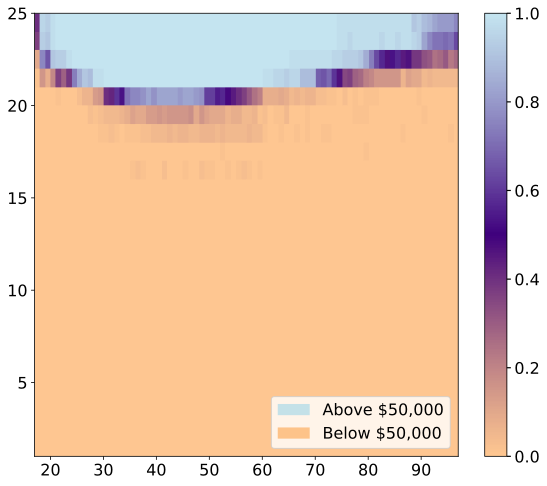

In [21]:
results = plot_decision_boundary_continuous("llama3_3_70B", 'income', ['AGEP', 'SCHL'], verbose=0, points_to_mark=0#started_below
, offset=0.5, cf_density=True, filepath = REPO_ROOT / "analysis/results_sensitivity/average_40.json",
save_path = REPO_ROOT / "figures/decision_boundary_50.png")